In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import sys
import numpy as np
import sympy as sym
from sympy.printing import octave_code, ccode
import copy
import scipy

new_paths = ['../Misc/', '../src', '../src/faultdiagnosistoolbox/build/lib.macosx-10.6-x86_64-2.7/', 'build/lib.macosx-10.6-x86_64-2.7/']
[sys.path.append(d) for d in new_paths if not d in sys.path];
from misc import *
import faultdiagnosistoolbox as fdt
import GetMeasurementData as gm

In [2]:
import VEP4Engine
reload(VEP4Engine)
model = VEP4Engine.model;
model.Lint()

Model: VEP4

  Type:Symbolic, dynamic

  Variables and equations
    90 unknown variables
    10 known variables
    11 fault variables
    94 equations, including 14 differential constraints

  Degree of redundancy: 4
  Degree of redundancy of MTES set: 1


  Model validation finished with 0 errors and 0 warnings.


In [ ]:
plt.figure(10)
model.PlotModel(verbose=False)

In [ ]:
plt.figure(20)
model.IsolabilityAnalysis(plot=True)

plt.figure(21)
model.IsolabilityAnalysis(plot=True, causality='int')

plt.figure(22)
model.IsolabilityAnalysis(plot=True, causality='der')

plt.figure(23)
model.PlotDM(fault=True,eqclass=True)

In [3]:
print "Searchin for MSO sets..."
msos = model.MSO()
print "Found " + str(len(msos)) + " MSO sets"

Searchin for MSO sets...
Found 4496 MSO sets


In [ ]:
print "Checking index properties of MSO sets..."
li = map(lambda m:model.IsLowIndex(m), msos)
print str(sum(li)) + " MSO sets are low-index"

In [4]:
# MSO selected in simple Kulback-Leibler selection strategy
ts = [ 1649, 4011, 4016, 4017, 4066, 4074, 4477]
re = [ 73  , 75  , 75  , 3   , 76  , 3   , 2]
for msoIdx,redIdx in zip(ts,re):
    mso = msos[msoIdx]
    red = mso[redIdx]
    m0 = [e for e in mso if e != red]
    Gamma = model.Matching(m0)
    print "MSO " + str(msoIdx) + " with redundant equation " + str(red) + ", causality: " + Gamma.matchType

MSO 1649 with redundant equation 1, causality: int
MSO 4011 with redundant equation 1, causality: int
MSO 4016 with redundant equation 1, causality: int
MSO 4017 with redundant equation 84, causality: int
MSO 4066 with redundant equation 1, causality: int
MSO 4074 with redundant equation 84, causality: int
MSO 4477 with redundant equation 86, causality: int


In [ ]:
tsFSM=model.FSM(msos[ts])
fIdx = [model.f.index(fi) for fi in ['fyw_af','fyp_im','fyp_ic','fyT_ic']]
plt.figure(30)
plt.spy(tsFSM[:,fIdx],markersize=6,marker="o", color="b")
plt.xticks(np.arange(0,len(fIdx)), np.array(model.f)[fIdx])
plt.yticks(np.arange(0,len(ts)), ["MSO " + str(k) for k in ts])
plt.gca().xaxis.tick_bottom()
plt.title('Fault Signature Matrix');

In [ ]:
for test,redIdx in zip(ts,re):
    mso = msos[test]
    red = mso[redIdx]
    m0 = [e for e in mso if e != red]
    resName = "ResGen_" + str(test) + "_" + str(red)
    Gamma = model.Matching(m0)
    model.SeqResGen(Gamma, red, resName, language='C', batch=True, user_functions=VEP4Engine.ext_funs,
               external_headers=['extmodelfuns.h'], external_src=['extmodelfuns.cc'])

In [ ]:
for test,redIdx in zip(ts,re):
    red = msos[test][redIdx]
    resName = "ResGen_" + str(test) + "_" + str(red)
    sys.stdout.write("Compiling residual generator: " + resName + " ... ")
    if os.system("CC=g++ python " + resName + "_setup.py build")==0:
        sys.stdout.write('Success!\n')
    else:
        sys.stdout.write('Failure!\n')

In [5]:
import ResGen_1649_1
import ResGen_4011_1
import ResGen_4016_1
import ResGen_4017_84
import ResGen_4066_1
import ResGen_4074_84
import ResGen_4477_86

In [6]:
dataDir = '/Users/frisk/Diagnos/Work/EngineDiagnosis/Work/Data/'
dataSets = {'NF' : 'driving_cycle_FTP75_highway_no_fault_dataset1_16-01-20.mat',
            'fyp_im' : 'driving_cycle_FTP75Highway_fault_y_pim_dataset_7_26-01-2016.mat',
            'fyw_af' : 'driving_cycle_FTP75Highway_fault_y_waf_dataset_5_26-01-2016',
            'fyp_ic' : 'driving_cycle_FTP75Highway_fault_y_pic_dataset_8_26-01-2016',
            'fyT_ic' : 'driving_cycle_FTP75Highway_fault_y_Tic_dataset_6_26-01-2016'}
data = {}
sys.stdout.write('Loading data ')
for dd in dataSets:
    sys.stdout.write('.')
    data[dd] = gm.GetMeasurementData(dataDir + dataSets[dd])
sys.stdout.write(' Finished loading ' + str(len(data.keys())) + ' datasets\n')
ftp75_hwfet = loadmat(dataDir + 'ftp75_hwfet.mat')
ftp75_hwfet = {'t': ftp75_hwfet['ftp75_hwfet']['t'], 'v':ftp75_hwfet['ftp75_hwfet']['v']}

Loading data ..... Finished loading 5 datasets


In [ ]:
plt.figure(90)
plt.plot(ftp75_hwfet['t']/60.0, ftp75_hwfet['v'], linewidth=2)
BoxOff()
plt.xlabel('t [min]')
plt.ylabel('Velocity [km/h]')
plt.title('EPA Highway Fuel Economy Test Cycle (HWFET)');

In [ ]:
DS = 500 # Down sanpling rate in plots
plt.figure(80)
plt.subplot( 3,3,1 )
yIdx = model.z.index('y_omega_e')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx]/(2*np.pi)*60 )
plt.ylabel('rpm')
plt.title('Engine speed')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))

plt.subplot( 3,3,2 )
yIdx = model.z.index('y_p_im')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx]/1e3 )
plt.ylabel('kPa')
plt.title('Intake manifold pressure')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))


plt.subplot( 3,3,3 )
yIdx = model.z.index('y_W_af')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx] )
plt.ylabel('kg/s')
plt.title('Air mass flow')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))


plt.subplot( 3,3,4 )
yIdx = model.z.index('y_alpha_th')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx] )
plt.ylabel('%')
plt.title('Throttle position')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))


plt.subplot( 3,3,5 )
yIdx = model.z.index('y_wfc')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx]*1.0e6 )
plt.ylabel('mg/s')
plt.title('Injected fuel')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))


plt.subplot( 3,3,6 )
yIdx = model.z.index('y_u_wg')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx] )
plt.ylabel('%')
plt.title('Wastegate')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))

plt.subplot( 3,3,7 )
yIdx = model.z.index('y_p_ic')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx]/1e3 )
plt.xlabel('t [min]')
plt.ylabel('kPa')
plt.title('Intercooler pressure')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))

plt.subplot( 3,3,8 )
yIdx = model.z.index('y_T_ic')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx] )
plt.xlabel('t [min]')
plt.ylabel('K')
plt.title('Intercooler temperature')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))


plt.subplot( 3,3,9 )
yIdx = model.z.index('y_p_amb')
plt.plot( data['NF']['time'][::DS]/60.0, data['NF']['z'][::DS,yIdx]/1.0e3 )
plt.xlabel('t [min]')
plt.ylabel('kPa')
plt.title('Ambient pressure')
plt.xlim([data['NF']['time'][0], data['NF']['time'][-1]/60])
BoxOff()
plt.gca().get_yaxis().set_major_locator(matplotlib.ticker.MaxNLocator(4))
plt.ylim(99,101)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Measurement data, no-fault dataset',fontsize=14, weight='bold');

In [7]:
r1 = RunResgenOnDataSets( ResGen_1649_1.ResGen_1649_1, data, VEP4Engine.diag_par )

  dataset fyw_af (0.52 sec, 1482.0 x real time @ 1000 Hz)
  dataset NF (0.52 sec, 1482.4 x real time @ 1000 Hz)
  dataset fyp_im (0.52 sec, 1486.2 x real time @ 1000 Hz)
  dataset fyp_ic (0.53 sec, 1443.2 x real time @ 1000 Hz)
  dataset fyT_ic (0.53 sec, 1459.1 x real time @ 1000 Hz)


['fyT_ic', 'fyw_af', 'fyp_im', 'fyp_ic', 'NF']

In [24]:
print "r1: MSO 1649" 
r1 = RunResgenOnDataSets( ResGen_1649_1.ResGen_1649_1, data, VEP4Engine.diag_par )
print "r2: MSO 4011" 
r2 = RunResgenOnDataSets( ResGen_4011_1.ResGen_4011_1, data, VEP4Engine.diag_par )
print "r3: MSO 4016" 
r3 = RunResgenOnDataSets( ResGen_4016_1.ResGen_4016_1, data, VEP4Engine.diag_par )
print "r4: MSO 4017" 
r4 = RunResgenOnDataSets( ResGen_4017_84.ResGen_4017_84, data, VEP4Engine.diag_par )
print "r5: MSO 4066" 
r5 = RunResgenOnDataSets( ResGen_4066_1.ResGen_4066_1, data, VEP4Engine.diag_par )
print "r6: MSO 4074" 
r6 = RunResgenOnDataSets( ResGen_4074_84.ResGen_4074_84, data, VEP4Engine.diag_par )
print "r7: MSO 4477" 
r7 = RunResgenOnDataSets( ResGen_4477_86.ResGen_4477_86, data, VEP4Engine.diag_par )
r = [r1, r2, r3, r4, r5, r6, r7]
for ri in r:
    if ri.has_key('NF'):
        bias = np.mean(ri['NF'])*0.0
        normFact = np.max(np.abs(ri['NF']-bias))*1.1
        for FM in ri:
                ri[FM] = 1/normFact*(ri[FM]-bias)

r1: MSO 1649
  dataset fyw_af (0.52 sec, 1473.2 x real time @ 1000 Hz)
  dataset NF (0.54 sec, 1448.3 x real time @ 1000 Hz)
  dataset fyp_im (0.54 sec, 1430.7 x real time @ 1000 Hz)
  dataset fyp_ic (0.54 sec, 1425.3 x real time @ 1000 Hz)
  dataset fyT_ic (0.53 sec, 1447.3 x real time @ 1000 Hz)
r2: MSO 4011
  dataset fyw_af (0.53 sec, 1438.2 x real time @ 1000 Hz)
  dataset NF (0.54 sec, 1446.8 x real time @ 1000 Hz)
  dataset fyp_im (0.51 sec, 1494.3 x real time @ 1000 Hz)
  dataset fyp_ic (0.53 sec, 1445.3 x real time @ 1000 Hz)
  dataset fyT_ic (0.56 sec, 1382.7 x real time @ 1000 Hz)
r3: MSO 4016
  dataset fyw_af (0.54 sec, 1421.7 x real time @ 1000 Hz)
  dataset NF (0.54 sec, 1446.8 x real time @ 1000 Hz)
  dataset fyp_im (0.53 sec, 1457.9 x real time @ 1000 Hz)
  dataset fyp_ic (0.53 sec, 1461.6 x real time @ 1000 Hz)
  dataset fyT_ic (0.52 sec, 1469.4 x real time @ 1000 Hz)
r4: MSO 4017
  dataset fyw_af (0.51 sec, 1499.2 x real time @ 1000 Hz)
  dataset NF (0.52 sec, 1509.7 x

In [31]:
alpha = 1e-3
J = np.zeros(len(r))
for ii,ri in enumerate(r):
    N = len(ri['NF'])
    foo = np.sort(np.abs(ri['NF']))
    J[ii] = foo[np.ceil(N*(1-alpha)).astype(np.int64)]

<IPython.core.display.Javascript object>


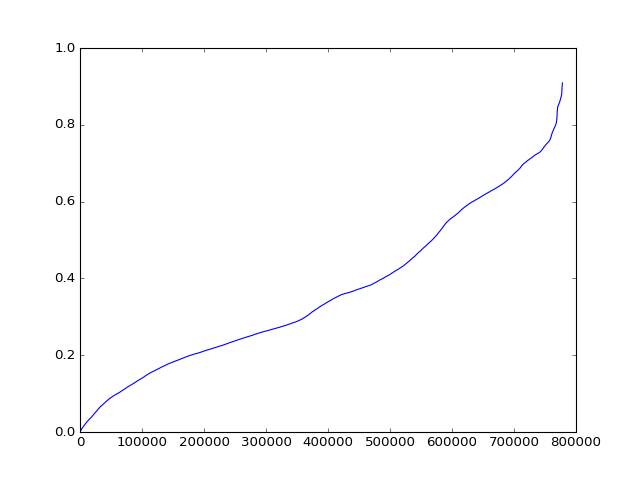

In [26]:
plt.figure(100)
plt.plot(foo)

In [ ]:
alpha = 1e-3;
J = zeros(numel(r),1);
for k=1:numel(r)
  N = numel(r{k}.NF);
  foo = sort(abs(r{k}.NF));
  J(k) = foo(ceil(N*(1-alpha)));
end
clear foo
